<a href="https://colab.research.google.com/github/basselkassem/easy21/blob/master/td_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Libs

In [1]:
!pip install import_ipynb

In [2]:
from google.colab import drive
drive.mount("/content/drive", )
%cd /content/drive/'My Drive'/'Colab Notebooks'/easy21

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks/easy21


# Import Libs

In [0]:
import import_ipynb
import environment as env
import numpy as np
from collections import defaultdict
import pickle
import matplotlib.pyplot as plt

#Implementation of Sarsa(λ):

* Initialise the value function to zero. 
* Use the same step-size and exploration schedules as in Monte-Carlo control. 
* Run the algorithm with parameter values λ = [0, 0.1, 0.2, ..., 1]. 
* Stop each run after 1000 episodes and report the mean-squared error sum(Q(s, a) − Q∗(s, a))2 over all states s and actions a, comparing the true values Q∗(s, a) computed in Monte-Carlo control with the estimated values Q(s, a) computed by Sarsa.
* Plot the mean-squared error against λ. For λ = 0 and λ = 1 only, plot the learning curve of mean-squared error against episode number.

# Load optimal Q from MonteCarlo

In [0]:
Q_star = None
with open('q_star.pickle_5', 'rb') as file:
    Q_star = pickle.load(file)

# Class SarsaLambda

In [0]:
class SarsaLambda:

    def __init__(self, td_lambda, N0, Q_star):
        self.td_lambda = td_lambda
        self.N0 = N0
        self.easy21 = env.Environment(mode = 'no_debug')
        self.Q = defaultdict(int)
        self.E = defaultdict(int)
        self.Nsa = defaultdict(int)
        self.Q_star = Q_star

    # compute the number of visiting state s
    def get_Ns(self, state):
        return self.Nsa[state, 0] + self.Nsa[state, 1]

    def epsilon_greedy(self, state):
        epsilon = self.N0 / (self.N0 + self.get_Ns(state))
        if np.random.random() < epsilon:
            hit = self.Q[state, 0]
            stick = self.Q[state, 1]
            if hit > stick:
                return 0
            if hit == stick:
                return self.easy21.sample_action()
            if hit < stick:
                return 1
        else:
            return self.easy21.sample_action()

    def agent_policy(self, state):
        return self.epsilon_greedy(state)

    def policy_evaluation(self, state, action):
        done = False
        next_action = None
        while not done:
            next_state, reward, done = self.easy21.step(state, action)
            if not done:
                next_action = self.agent_policy(next_state)
                td_error = reward + self.Q[next_state, next_action] - self.Q[state, action]
            else:
                td_error = reward - self.Q[state, action]
            self.E[state, action] += 1
            self.Nsa[next_state, next_action] += 1
            self.ploicy_imporvment(td_error)
            if not done:
                state = next_state
                action = next_action 

    def ploicy_imporvment(self, td_error):
        for (state, action), e in self.E.items():
            alpha = 1 / (self.Nsa[state, action])
            self.Q[state, action] += alpha * td_error * self.E[state, action]
            self.E[state, action] *= self.td_lambda

    def policy_iteration(self, episodes_num = 1000, episodes_error = False):
        errors = []
        for episode in np.arange(episodes_num):
            self.E = defaultdict(int)
            self.easy21 = env.Environment(mode = 'no_debug')
            state, _, done = self.easy21.init()
            action = self.agent_policy(state)
            self.Nsa[state, action] += 1
            self.policy_evaluation(state, action)
            if episodes_error == True:
                errors.append(self.compute_error(self.Q))
        if episodes_error == True:
            return errors
        else:
            return self.compute_error(self.Q)
    
    def compute_error(self, Q):
        error = 0
        for state_action, value in self.Q_star.items():
            error += (value - Q[state_action]) **2
        return error / len(self.Q_star)    

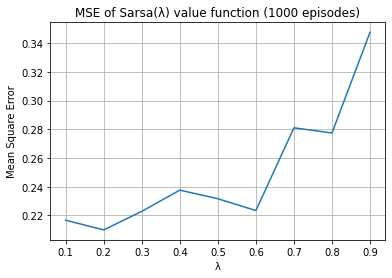

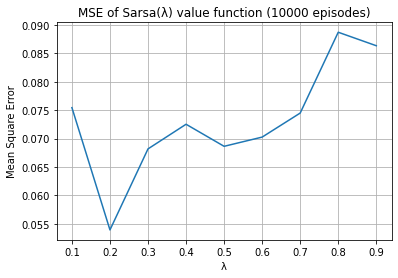

In [58]:
def mse_plot(episodes_num):
  mse_errors = []
  for lamb in env.TD_LAMBDA:
    agent = SarsaLambda(lamb, 100, Q_star)
    error = agent.policy_iteration(episodes_num = episodes_num)
    mse_errors.append(error)

  plt.plot(env.TD_LAMBDA, mse_errors)
  plt.xlabel('λ')
  plt.ylabel('Mean Square Error')
  plt.title('MSE of Sarsa(λ) value function ({} episodes)'.format(episodes_num))
  plt.grid(True)
  plt.show()
mse_plot(1000)
mse_plot(10000)

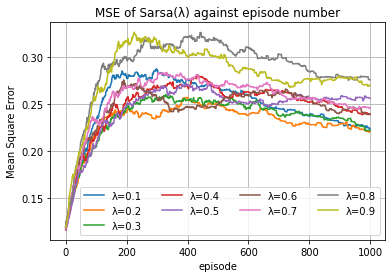

In [52]:
def mse_episodes_plot(td_lambda, episodes_num):
  for lamb in td_lambda:
    agent = SarsaLambda(lamb, 100, Q_star)
    errors = agent.policy_iteration(episodes_error = True, episodes_num = episodes_num)
    plt.plot(list(range(episodes_num)), errors)
  
  plt.legend(['λ={:0.1f}'.format(lamb) for lamb in td_lambda], ncol=4)
  plt.xlabel('episode')
  plt.ylabel('Mean Square Error')
  plt.title('MSE of Sarsa(λ) against episode number')
  plt.grid(True)
  plt.show()
mse_episodes_plot(env.TD_LAMBDA, 1000)

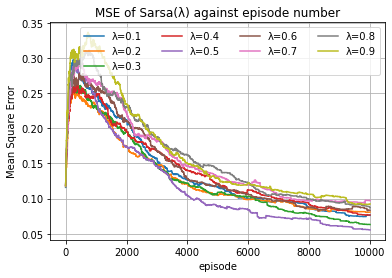

In [53]:
mse_episodes_plot(env.TD_LAMBDA, 10000)

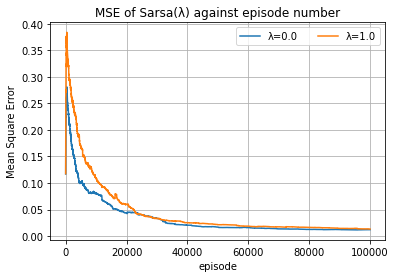

In [55]:
mse_episodes_plot([0, 1], 100000)

## Draw resullt

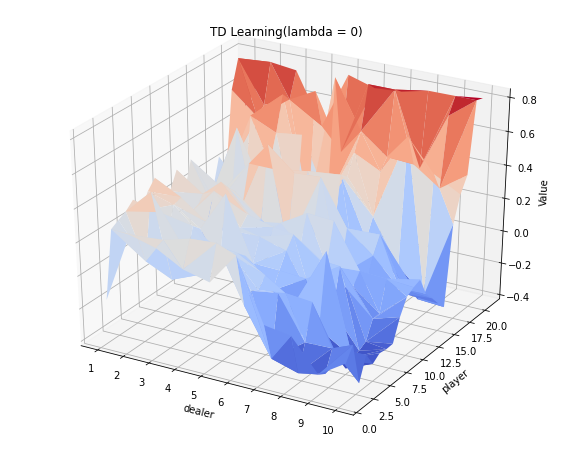

In [67]:
agent = SarsaLambda(0, 100, Q_star=Q_star)
agent.policy_iteration(episodes_num=10**4)
title = 'TD Learning(lambda = 0)'
env.Visualizer.visualize(agent.Q, title)

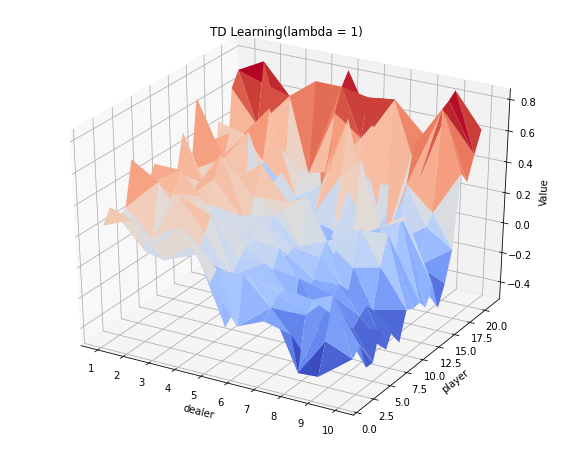

In [66]:
agent = SarsaLambda(1, 100, Q_star=Q_star)
agent.policy_iteration(episodes_num=10**4)
title = 'TD Learning(lambda = 1)'
env.Visualizer.visualize(agent.Q, title)